<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2021 Reduction Exercise: Part 4</h2>

The goal of this part is to produce a color-magnitude diagram for your cluster.  Do do this we need to detect stars, measure their flux, compare it to a known magnitude for that star, derive the magnitude zeropoint for that band, and convert all of your fluxes to magnitudes.  This will be broked into the following steps:

1. read in image with a valid astrometric header (the output image from the end of part 4);
2. Locate stars in this image and measure their flux;
3. query the online PAN-STARRS catalog and retrieve all of the objects in the vicinity of our image;
4. Cross-match the two lists to find which object corresponds to which;
5. Compare the true magnitude and instrumental magnitude to determine the magnitude zeropoint of your image, i.e. what magnitude is a single count;
6. Use this to create magnitudes in each band
7. Produce a color-magnitude diagram
8. Determine which isochrones fit the data best

There are **4 problems** that you will need to answer throughout this notebook

## Due Dec. 1st at noon

In [7]:
from astropy.io import fits
from astropy.nddata import CCDData
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from astropy.table import Table
from astropy.stats import sigma_clipped_stats

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import scoreatpercentile
import glob
import time
import os

#************ Change this
redpath = "/media/miearsje/easystore/Documents/KU/Past Courses/Fall2021/ASTR596/mine/ObservingProject_student/Data/2021-10-19/Reduced/"

A routine to display in image

In [14]:
def display_image(imagename,cmap='viridis',p1=5,p2=99.5,stretch='asinh'):
  d = fits.getdata(imagename)
  a = scoreatpercentile(d,p1)
  b = scoreatpercentile(d,p2)
  norm = simple_norm(d,min_percent=p1,max_percent=p2)  
  #plt.figure(figsize=(12,10))
  #plt.imshow(d,vmin=a,vmax=b,cmap=cmap,norm=norm)
  plt.imshow(d,cmap=cmap,norm=norm)

# solve for zeropoint and measure photometry for objects in an image

* The photometric zeropoint allows us to convert the flux we measure on the image to a magnitude.

* The relationship is
$$ m = ZP - 2.5 log_{10}(flux) $$
where flux is measured in ADU.  Normally, we would divide the image frames by the exposure time.  The zeropoint in then the magnitude that corresponds to a source with a flux of 1ADU/s. But for now, we won't worry about normalizing by exposure time.

* Instrumental magnitude refers to the second term
$$ m_{inst} = -2.5 log_{10}(flux) $$

What follows are routines needed to complete steps 1-5 from the beginning of this file

In [15]:
#this imports a function
from scipy.optimize import curve_fit

#this is something we'll need later to just add the ZP to the instrumental magnitude
def fitZP(instmag,zp):
  return instmag + zp

In [16]:
from photutils import DAOStarFinder
from photutils import CircularAperture

In [17]:
# some phot functions

#this routine measueres the background and subtracts it
def get_sky_background(img, verbose=False):
    from astropy.stats import sigma_clipped_stats
    # estimate background counts in image
    mean, median, std = sigma_clipped_stats(img, sigma=3.0)
    return median,std

# this detects stars using the DAOStarFinder algorithm (you can look it up)
def find_stars(img, fwhm=3.0, nsigma=5, verbose=False):
    from photutils import DAOStarFinder

    bkg,sigma = get_sky_background(img, verbose=verbose)
    
    daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma * sigma)
    srcs = daofind(img - bkg)
    if verbose:
        print('Found {} stars'.format(len(srcs)))    
    return srcs

#this queries the PAN-STARRS catalog
def get_panstarrs_catalog(imgwcs, radius=0.2, verbose=False, maxsources=10000):
    """
    FOUND THIS ON THE WEB 
    https://mommermi.github.io/astronomy/2017/02/14/accessing-the-gaia-and-pan-starrs-catalogs-using-python.html    
    
    Query PanSTARRS @ VizieR using astroquery.vizier
    :param ra_deg: RA in degrees
    :param dec_deg: Declination in degrees
    :param rad_deg: field radius in degrees
    :param maxmag: upper limit G magnitude (optional)
    :param maxsources: maximum number of sources
    :return: astropy.table object
    """

    import astropy.units as u
    from astropy.coordinates import SkyCoord
    from astroquery.vizier import Vizier

    ra0, dec0 = imgwcs.wcs.crval
    coords = SkyCoord(ra0, dec0, unit=u.deg, frame='icrs')
    
    if verbose:
        print('Querying Pan-STARRS {:.3f} deg around RA, Dec={:.5f}, {:.5f} '.format(radius, ra0, dec0))
    
    pan_columns =['objID', 'RAJ2000', 'DEJ2000','gmag', 'rmag','imag','zmag', 'ymag']
    #print(pan_columns)
    pan_columns_mast = ['objID', 'raMean', 'decMean','gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag']
        
    vquery = Vizier(columns=pan_columns,
                        column_filters={"gmag":"<18","gmag":"> 8",
                                        "rmag":"<18","rmag":"> 8",
                                        "imag":"<18","imag":"> 8",
                                        "zmag":"<18","zmag":"> 8"},   
                        row_limit=maxsources)

    cat = vquery.query_region(coords, width=radius*u.deg, catalog="II/349/ps1")[0]

    # to make this compatible with original version that pulled catalog from MAST
    for c1,c2 in zip(pan_columns,pan_columns_mast):
        cat.rename_column(c1,c2)
    # color cut
    gi = cat['gMeanPSFMag'] - cat['iMeanPSFMag']
    keep = np.where( (gi > 0.4) * (gi < 2.7) )[0]
    cat = cat[keep]
    if verbose:
        print('Number of objects in panstarrs catalog = {}'.format(len(cat)))
        
    return cat

#This plots the location of all the stars we detected in the data
def show_stars(image_filename,star_cat,matchflag,p1=25,p2=95):
    display_image(image_filename,p1=p1,p2=p2,cmap='Greys')

    positions = np.transpose((star_cat['xcentroid'], star_cat['ycentroid']))
    apertures = CircularAperture(positions, r=4.)
    #norm = ImageNormalize(stretch=SqrtStretch())
    apertures.plot(color='blue', lw=3, alpha=0.5)

    #just the matching stars
    positions_m = np.transpose((star_cat['xcentroid'][matchflag], star_cat['ycentroid'][matchflag]))
    apertures_m = CircularAperture(positions, r=7.)
    apertures.plot(color='red', lw=3, alpha=0.5)
    
def match_image_2_panstarrs(image_filename,band='r',maxoffset=5,fwhm=5,showstars=True):
    '''
    GOAL: match star catalog to panstarrs catalog

    INPUT:
    * image_filename: image to solve for ZP
    * band : photometric band of image (g or r)
    * maxoffset : max offset to allow when matching source on image to pansstars; default is 5"

    RETURNS:
    * instrumental magnitude of matched sources
    * panstarrs magnitude of matched sources  
    * star_cat : the catalog of stars from DAOfind
    '''
    # First find stars in our data
    data,header = fits.getdata(image_filename,header=True)
    w = WCS(header)
    star_cat = find_stars(data)

    #Then use the WCS in the header to convert the x,y coordinates of those 
    #stars to RA,DEC
    ra1,dec1 = w.wcs_pix2world(star_cat['xcentroid'],star_cat['ycentroid'],0)
    # create skycoord for cat1.  This is a special format of catalog used for matching
    scatalog = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)

    # get pansstarrs catalog
    panstarrs_cat = get_panstarrs_catalog(w)
    # create skycoord for cat2
    pcatalog = SkyCoord(ra=panstarrs_cat['raMean'], dec=panstarrs_cat['decMean'])
    # match panstarrs catalog to detected stars
    idx, d2d, d3d = scatalog.match_to_catalog_sky(pcatalog)
    matchflag = d2d < 5./3600*u.deg
  
    if band == 'r':
      field = 'rMeanPSFMag'
    elif band == 'g':
      field = 'gMeanPSFMag'

    
    instrument_mag = -2.5*np.log10(star_cat['flux'][matchflag])
    panstarrs_mag = panstarrs_cat[field][idx[matchflag]]
    if showstars:
      # plot image
      plt.figure(figsize=(20,12))
      # show the image, then with the stars marked
      plt.subplot(1,2,1)
      display_image(image_filename,p1=25,p2=95)
      plt.subplot(1,2,2)
      show_stars(image_filename,star_cat,matchflag)


    return instrument_mag,panstarrs_mag,star_cat


  


### solve ZP for R-band image

In the images below, the left image shows our field.  The right image shows it in grayscale with all the detected stars in blue and all those with a counterpart in the PAN-STARRS catalog in red.

CPU times: user 3.99 s, sys: 200 ms, total: 4.19 s
Wall time: 4.21 s


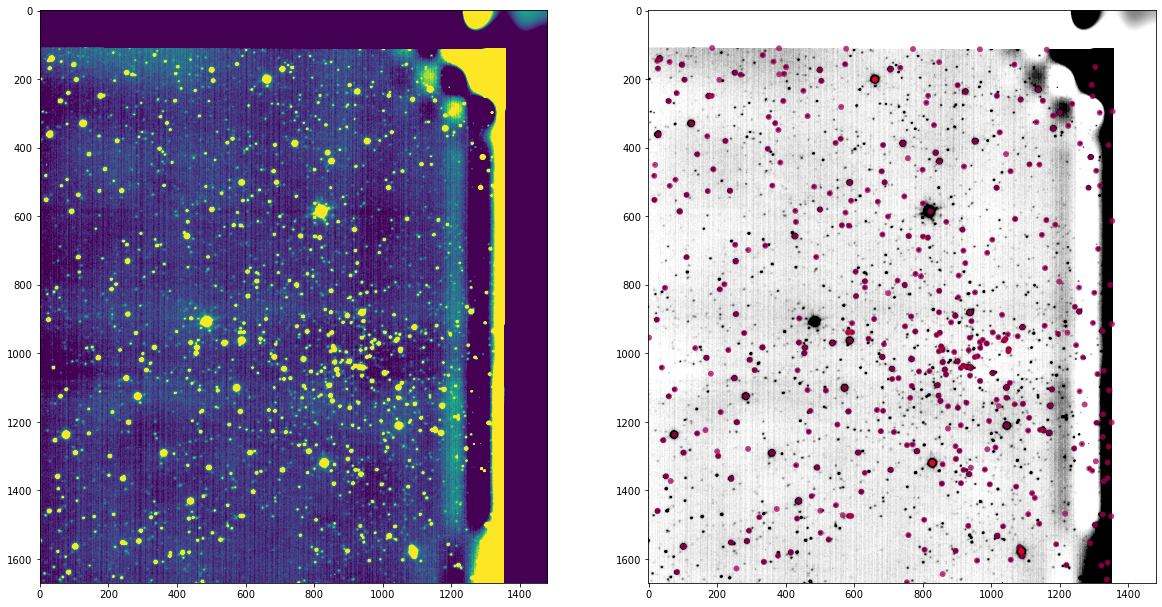

In [18]:
%%time
# get panstarrs catalog for r-band image
rimage_filename = redpath + 'mark50r-stacked-bkgsub.fit'
rinst_mag,rpansstars_mag,rstar_cat = match_image_2_panstarrs(rimage_filename,band='r')

### Derive zeropoint.

We compare the "true" magnitudes from PAN-STARRS with our instrumental magnitudes and use the difference between them to get the zeropoint.  We do this using two ways of fitting the relation between the instrumental and PAN-STARRS magnitudes.

In the plot we show those stars in red as the ones we use to get the fit.  

ZP from curve_fit = 16.44+/-0.00
ZP from polyfit = 16.39, with slope=0.95


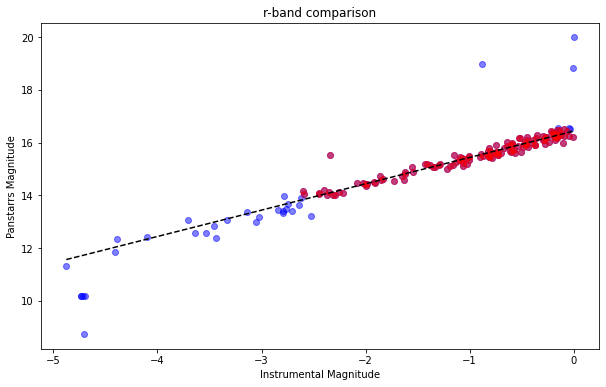

In [19]:
# make a plot of pansstars_mag vs inst_mag, and solve for the photometric zeropoint
# use only the points with panstarrs magnitudes between 14 and 16.5 .  This is to
# only use stars are bright enough for a precise measurement, but not so bright as to be 
# saturated
plt.figure(figsize=(10,6))
flag = (rpansstars_mag > 14) & (rpansstars_mag < 16.5)

#plot all matches in blue, and those in the fit range in red
plt.plot(rinst_mag,rpansstars_mag,'bo',alpha=.5,markersize=6)
plt.plot(rinst_mag[flag],rpansstars_mag[flag],'ro',alpha=.5,markersize=6)

#fit a line to these data using the scipy curve_fit function
popt,pcov = curve_fit(fitZP,xdata=rinst_mag[flag],ydata=rpansstars_mag[flag])

#fit a line using the numpy polyfit function
c = np.polyfit(rinst_mag[flag],rpansstars_mag[flag],1)

#draw the best-fit line from the curve_fit function
xline = np.linspace(min(rinst_mag),max(rinst_mag),100)
yline = xline+popt[0]
plt.plot(xline,yline,'k--')

plt.xlabel('Instrumental Magnitude')
plt.ylabel('Panstarrs Magnitude')
plt.title('r-band comparison')
print('ZP from curve_fit = {:.2f}+/-{:.2f}'.format(popt[0],pcov[0][0]))
print('ZP from polyfit = {:.2f}, with slope={:.2f}'.format(c[1],c[0]))
rZP = popt[0]

## problem 1

Why are there stars at the right of this plot that are very much above the line?

**answer here**: There are also some stars on the left which are very much above the line... is that relevant? They're also blue instead of red, so are these just stars which weren't within the range we were looking at?

## repeat for the g-band

CPU times: user 3.84 s, sys: 268 ms, total: 4.11 s
Wall time: 4.12 s


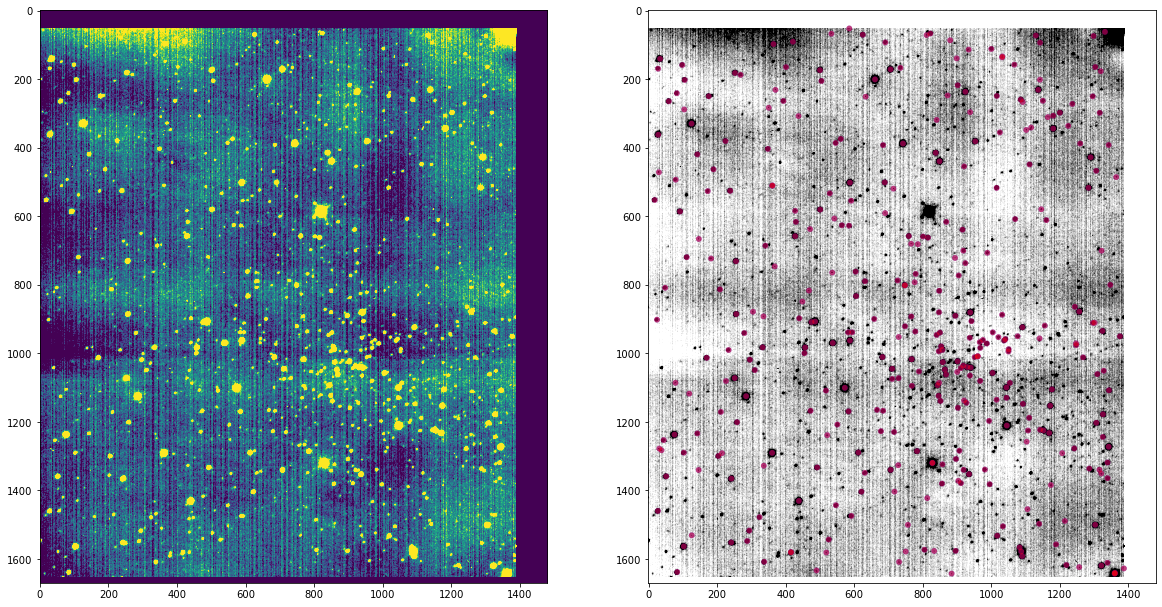

In [20]:
%%time
# get panstarrs catalog for r-band image
gimage_filename = redpath + 'mark50g-stacked-bkgsub.fit'
ginst_mag,gpansstars_mag,gstar_cat = match_image_2_panstarrs(gimage_filename,band='g')

ZP from curve_fit = 17.05+/-0.00
ZP from polyfit = 17.00, with slope=0.97


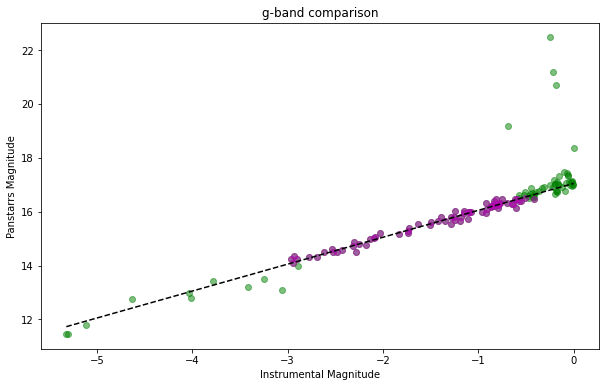

In [21]:
# make a plot of pansstars_mag vs inst_mag, and solve for the photometric zeropoint
# use only the points with panstarrs magnitudes between 14 and 16.5 .  This is to
# only use stars are bright enough for a precise measurement, but not so bright as to be 
# saturated
plt.figure(figsize=(10,6))
flag = (gpansstars_mag > 14) & (gpansstars_mag < 16.5)

#plot all matches in blue, and those in the fit range in red
plt.plot(ginst_mag,gpansstars_mag,'go',alpha=.5,markersize=6)
plt.plot(ginst_mag[flag],gpansstars_mag[flag],'mo',alpha=.5,markersize=6)

#fit a line to these data using the scipy curve_fit function
popt,pcov = curve_fit(fitZP,xdata=ginst_mag[flag],ydata=gpansstars_mag[flag])

#fit a line using the numpy polyfit function
c = np.polyfit(ginst_mag[flag],gpansstars_mag[flag],1)

#draw the best-fit line from the curve_fit function
xline = np.linspace(min(ginst_mag),max(ginst_mag),100)
yline = xline+popt[0]
plt.plot(xline,yline,'k--')

plt.xlabel('Instrumental Magnitude')
plt.ylabel('Panstarrs Magnitude')
plt.title('g-band comparison')
print('ZP from curve_fit = {:.2f}+/-{:.2f}'.format(popt[0],pcov[0][0]))
print('ZP from polyfit = {:.2f}, with slope={:.2f}'.format(c[1],c[0]))
gZP = popt[0]

## problem 2

Based on the zeropoint, What would be the g and r-band magnitudes of a star with 50 counts in each band?

**answer here**: For the g-band, $ZP_g(\lambda) \approx 17$ and $c^{ref}_{star}(\lambda) = 50$, 
<br><br>
<center>
    $m^{ref}_{star}(\lambda) = ZP_g(\lambda) - 2.5 \log c^{ref}_{star}(\lambda)$<br>
    $m^{ref}_{star}(\lambda) = 17 - 2.5 \log 50$<br>
    $m^{ref}_{star}(\lambda) = \boxed{12.8}$
</center>
<br>
Now for the r-band, where $ZP_r(\lambda) \approx 16.4$ and $c^{ref}_{star}(\lambda) = 50$,
<br><br>
<center>
    $m^{ref}_{star}(\lambda) = ZP_r(\lambda) - 2.5 \log c^{ref}_{star}(\lambda)$<br>
    $m^{ref}_{star}(\lambda) = 16.4 - 2.5 \log 50$<br>
    $m^{ref}_{star}(\lambda) = \boxed{12.2}$
</center>

#### Now calculate the magnitudes

In [28]:
# calculate the r-band magnitude
rmag = rZP-2.5*np.log10(rstar_cat['flux'])
gmag = gZP-2.5*np.log10(gstar_cat['flux'])


## Now use the WCS to match the catalogs between the g and r-band images

In [29]:
data,header = fits.getdata(rimage_filename,header=True)
w = WCS(header)
rra,rdec = w.wcs_pix2world(rstar_cat['xcentroid'],rstar_cat['ycentroid'],0)
rcoord = SkyCoord(ra=rra*u.degree, dec=rdec*u.degree)

gra,gdec = w.wcs_pix2world(gstar_cat['xcentroid'],gstar_cat['ycentroid'],0)
gcoord = SkyCoord(ra=gra*u.degree, dec=gdec*u.degree)
# match panstarrs catalog to detected stars
idx, d2d, d3d = rcoord.match_to_catalog_sky(gcoord)
matchflag = d2d < 2./3600*u.deg

rmatch = rmag[matchflag]
gmatch = gmag[idx[matchflag]]
grmatch = gmatch - rmatch

Text(0.5, 1.0, 'Markarian 50 H-R Diagram')

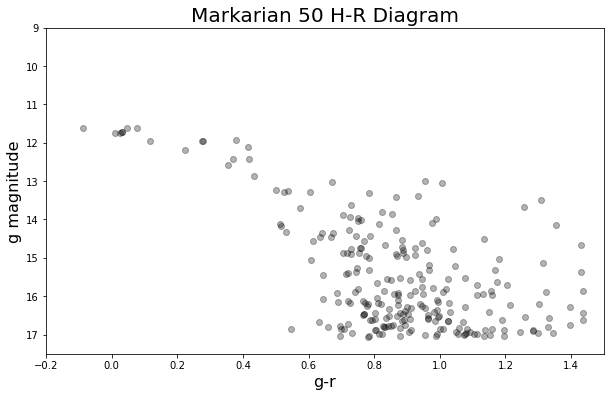

In [30]:
# plot HR diagram!!!

plt.figure(figsize=(10,6))
plt.plot(gmatch-rmatch,gmatch,'ko',alpha=.3,markersize=6)

plt.xlabel('g-r',fontsize=16)
plt.ylabel('g magnitude',fontsize=16)
plt.axis([-.2,1.5,9,17.5])
plt.gca().invert_yaxis()
plt.title('Markarian 50 H-R Diagram',fontsize=20)


## problem 3

Describe this diagram to me.  What parts of this diagram do you recognize?  What components do you not see and what might this tell you?

**answer here**: It looks like the stars are largely still on the main sequence, and don't seem to have stars which have aged enough to start developing into Red Giants. This tells me the cluster is rather young. 

## Now plot isochrones

The code below reads in theoretical isochrones that I downloaded from an online source.  In the second block of code you will need to vary with the isochrone age to answer the question at the bottom of the notebook.

In [31]:
#these are from http://stev.oapd.inaf.it/cgi-bin/cmd
#isodat = astropy.table.read('output227701722717.dat',format='ascii')
#log(age) to 9.8 with 0.2 log spacing 
filename = 'output571753586017.dat'

isodat = Table.read(filename,format='ascii')
logage = isodat['col3']
mass = isodat['col6']
isog = isodat['col29']
isor = isodat['col30']


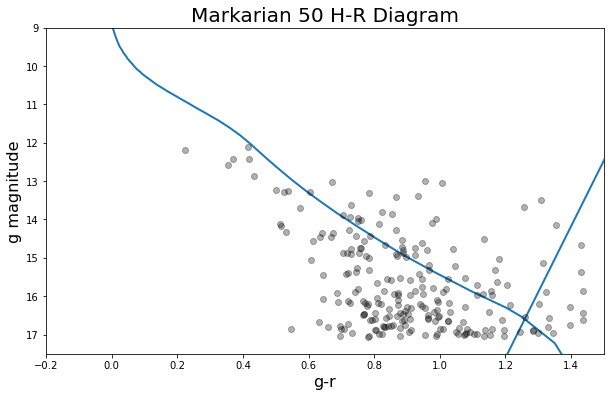

In [74]:
# plot HR diagram!!!

plt.figure(figsize=(10,6))
nonsatflag = gmatch>12
plt.plot(gmatch[nonsatflag]-rmatch[nonsatflag],gmatch[nonsatflag],'ko',alpha=.3,markersize=6)

plt.xlabel('g-r',fontsize=16)
plt.ylabel('g magnitude',fontsize=16)
plt.axis([-.2,1.5,9,17.5])
plt.gca().invert_yaxis()
plt.title('Markarian 50 H-R Diagram',fontsize=20)

# plot isochrone with a log(age/yr) starting at 7.0 going to 9.8 in units of logage(0.2)
#****************
#play with these ages until you find the oldest age that fits the data
target_age = 8.6

#this finds which isochrone from the data best matches the target age.
agedist = abs(logage - target_age)
ageflag = (agedist<0.01)

#this part uses a published distance to the cluster and the AV from from the WebDA 
#data base to dim and redden the isochrones
d = 3460.0 #pc
DM = 5 + np.log10(d/10.0)     #the distance modulus

#the extinction in mag from the Webda database
AV = 0.81

#these numbers are specific to the filters and give the ratio of A(lambda)/AV
Ag_AV = 1.18
Ar_AV = 0.86
plt.plot(isog[ageflag] + Ag_AV*AV - ( isor[ageflag] + Ar_AV*AV),isog[ageflag]+Ag_AV*AV+DM,lw=2,zorder=1)

## problem 4
By playing with the isochrone ages in the previous code block, give an **upper limit** on what you think the age can be in *Myr*.

Can you think of anything in how we plotted the isochrones that could complicate this interpretation?


**answer here**: After changing the age several times, the upper limit seems to be approximately 8.6 Myr. Would the filters we used cause any complications? Or possibly how we calculated the zero point?